In [1]:
# default_exp preprocessing
%load_ext autoreload
%autoreload 2

# pre_processing


> API details.

In [2]:
#hide
from nbdev.showdoc import *

![preprocessing](images/graphic8.PNG)

In [3]:
#export
import pydicom,kornia,skimage
from fastai.vision.all import *
from fastai.medical.imaging import *
from torchvision.utils import save_image
import seaborn as sns

from fmi.pipeline import *
from fmi.explore import get_dicom_image

### Mask & Save

> Note: View Mask & Save tutorial on Kaggle (click on Kaggle icon)

[<img src="images/kaggle.PNG" alt="kaggle" align="left" width="80" height="36" />](https://www.kaggle.com/avirdee/mask-and-save-tutorial/)

In [4]:
#export
def mask_and_save_path(file: (L), source=None, show=False, window=dicom_windows.lungs, sigma:float=0.1,\
                  thresh:float=0.9, save=False, save_path=None):
    "Helper to create masks based on dicom window with the option to save the updated image from path"
    image_list = []
    for i in file:
        ##This line will have to be changed depending on what platform is being used
        str_file = str(i); file_name = str_file.split('.')[0].split('\\')[-1] #windows
        #str_file = str(i); file_name = str_file.split('/')[-1].split('.')[0] #kaggle
        dcm = i.dcmread()
        wind = dcm.windowed(*window)
        mask = dcm.mask_from_blur(window, sigma=sigma, thresh=thresh, remove_max=False)
        bbs = mask2bbox(mask)
        lo,hi = bbs
        imh = wind[lo[0]:hi[0],lo[1]:hi[1]]
        if save is not False:
            if not os.path.exists(save_path):
                os.makedirs(save_path)   
            save_image(imh, f'{save_path}/{file_name}.jpg')
        else:
            pass
        image_list.append(imh)
    if show is not False:
        show_images(image_list[:10], nrows=1)
    else:
        pass

In [5]:
show_doc(mask_and_save_path)

<h4 id="mask_and_save_path" class="doc_header"><code>mask_and_save_path</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>mask_and_save_path</code>(**`file`**:`L`, **`source`**=*`None`*, **`show`**=*`False`*, **`window`**=*`(1500, -600)`*, **`sigma`**:`float`=*`0.1`*, **`thresh`**:`float`=*`0.9`*, **`save`**=*`False`*, **`save_path`**=*`None`*)

Helper to create masks based on dicom window with the option to save the updated image from path

In [6]:
#export
def mask_and_save_df(file: (pd.DataFrame), source, show=False, folder='PatientID', instance='InstanceNumber', \
                     window=dicom_windows.lungs, sigma:float=0.1, thresh:float=0.9, save=False, save_path=None):
    "Helper to create masks based on dicom window with the option to save the updated image from a dataframe"
    image_list = []
    for i in file.index:
        file_path = Path(f"{source}/{file.iloc[i][folder]}/{file.iloc[i][instance]}.dcm")
        file_name = file.iloc[i][instance]
        dcm = file_path.dcmread()
        wind = dcm.windowed(*window)
        mask = dcm.mask_from_blur(window, sigma=sigma, thresh=thresh, remove_max=False)
        bbs = mask2bbox(mask)
        lo,hi = bbs
        imh = wind[lo[0]:hi[0],lo[1]:hi[1]]
        if save is not False:
            if not os.path.exists(save_path):
                os.makedirs(save_path)   
            save_image(imh, f'{save_path}/{file_name}.jpg')
        else:
            pass
        image_list.append(imh)
    if show is not False:
        show_images(image_list[:10], nrows=1)
    else:
        pass

In [7]:
show_doc(mask_and_save_df)

<h4 id="mask_and_save_df" class="doc_header"><code>mask_and_save_df</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>mask_and_save_df</code>(**`file`**:`DataFrame`, **`source`**, **`show`**=*`False`*, **`folder`**=*`'PatientID'`*, **`instance`**=*`'InstanceNumber'`*, **`window`**=*`(1500, -600)`*, **`sigma`**:`float`=*`0.1`*, **`thresh`**:`float`=*`0.9`*, **`save`**=*`False`*, **`save_path`**=*`None`*)

Helper to create masks based on dicom window with the option to save the updated image from a dataframe

`fastai` has a handy method `from.dicoms` that can access dicom metadata and display this in a dataframe.

In [8]:
m_items = get_dicom_files('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430')
source = 'D:/Datasets/osic-pulmonary-fibrosis-progression/train/'
dicom_dataframe = pd.DataFrame.from_dicoms(m_items)
dicom_dataframe[:2]

,SpecificCharacterSet,ImageType,SOPInstanceUID,Modality,Manufacturer,ManufacturerModelName,PatientName,PatientID,PatientSex,DeidentificationMethod,...,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,ORIGINAL,2.25.12297650151329871895440507938349160734,CT,GE MEDICAL SYSTEMS,LightSpeed VCT,"(I, D, 0, 0, 0, 0, 7, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 1, 1, 9, 5, 6, 4, 3, 0)",ID00007637202177411956430,,Table;,...,0.0,1.0,0.0,1,0.652344,-2000,2842,-1.454884,1137.488858,0.058094
1,ISO_IR 100,ORIGINAL,2.25.37611372879908126511187998276199853341,CT,GE MEDICAL SYSTEMS,LightSpeed VCT,"(I, D, 0, 0, 0, 0, 7, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 1, 1, 9, 5, 6, 4, 3, 0)",ID00007637202177411956430,,Table;,...,0.0,1.0,0.0,1,0.652344,-2000,2918,19.038597,1138.876560,0.068130


To see how `mask_and_save` works here are 10 original images (we can use `get_dicom_image` to view the images). To save the images in `png` format change save to `True` and set a `save_path`

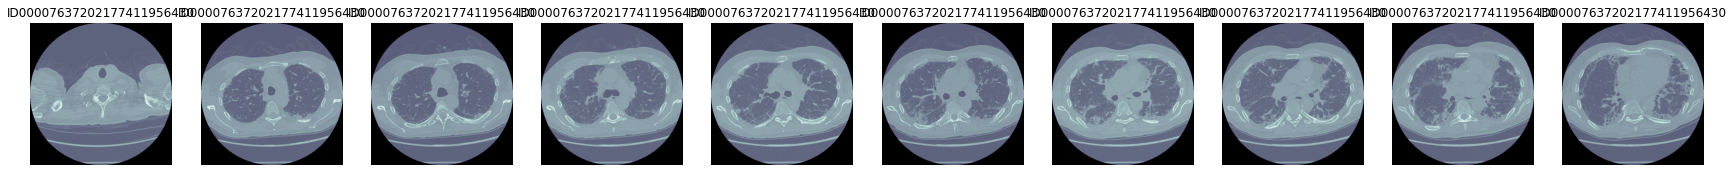

In [9]:
get_dicom_image(dicom_dataframe[:10], 'PatientID', folder_val='PatientID', instance_val='InstanceNumber', source=source, nrows=1)

Using a sigma of `0.2` and a lung window

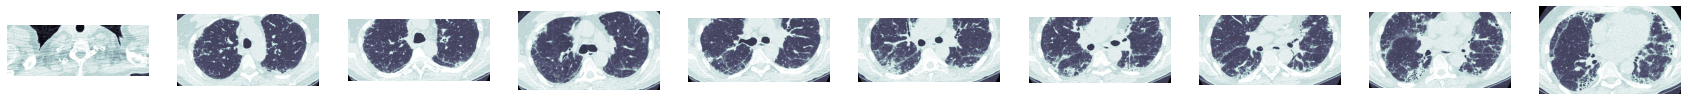

In [10]:
#sigma 0.2
mask_and_save_df(dicom_dataframe[:10], window=dicom_windows.lungs, show=True, source=source, sigma=0.2, save=False)

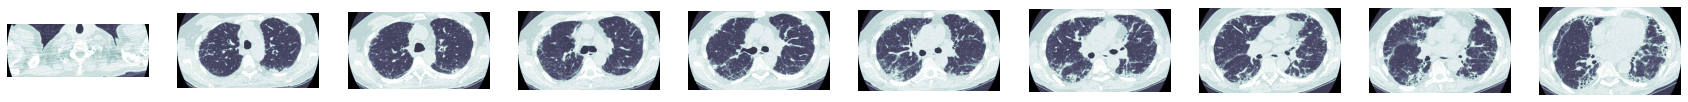

In [11]:
#sigma 0.1
mask_and_save_df(dicom_dataframe[:10], window=dicom_windows.lungs, show=True, source=source, sigma=0.1, save=False)

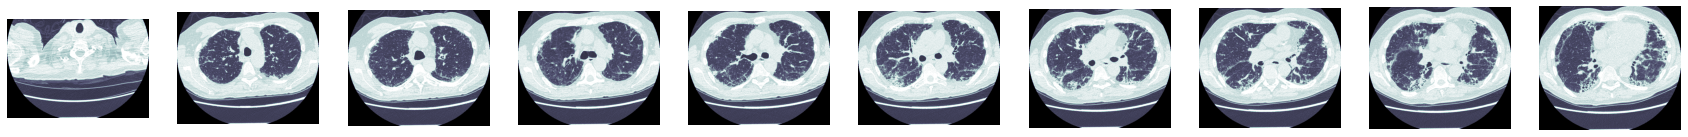

In [12]:
#sigma 0.01
mask_and_save_df(dicom_dataframe[:10], window=dicom_windows.lungs, show=True, source=source, sigma=0.01, save=False)

Setting the `sigma` value to 0.1 reduces the image area only to the areas that are important

### Image Hist

In [13]:
#export
def image_hist(file: (L), window=dicom_windows.lungs, sigma:float=0.1, thresh:float=0.9):
    "Helper that creates masks based on dicom window and plots corresponding histogram"
    dcm = file.dcmread()
    wind = dcm.windowed(*window)
    mask = dcm.mask_from_blur(window, sigma=sigma, thresh=thresh, remove_max=False)
    bbs = mask2bbox(mask)
    lo,hi = bbs
    imh = wind[lo[0]:hi[0],lo[1]:hi[1]]
    imha = array(imh)
    sns.histplot(imha.ravel(), bins=256, element='bars')
    show_image(imh)

In [14]:
show_doc(image_hist)

<h4 id="image_hist" class="doc_header"><code>image_hist</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>image_hist</code>(**`file`**:`L`, **`window`**=*`(1500, -600)`*, **`sigma`**:`float`=*`0.1`*, **`thresh`**:`float`=*`0.9`*)

Helper that creates masks based on dicom window and plots corresponding histogram

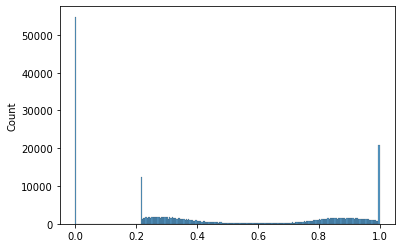

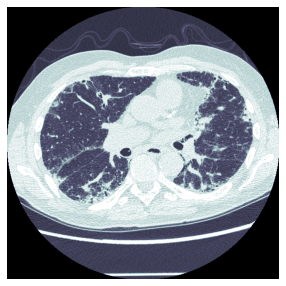

In [15]:
image_hist(m_items[7], window=dicom_windows.lungs, sigma=0.0, thresh=0.0)

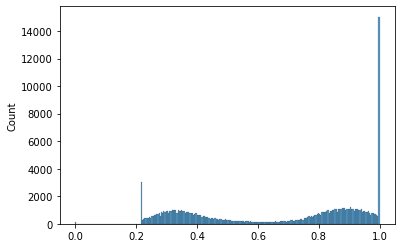

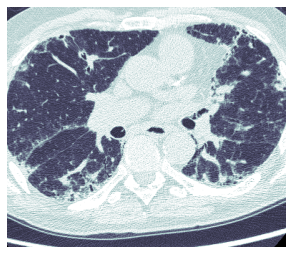

In [16]:
image_hist(m_items[7], window=dicom_windows.lungs, sigma=0.9, thresh=0.5)

### Dicom metadata dict

<img src="images/git_merged.PNG" alt="merged" align="left"
	width="124" height="59" />
    
This update has been successfully merged with `fastai.medical.imaging`

Currently the in house `from_dicoms` does not allow you to input the window parameters, this updated version however does

In [17]:
#export
def _dcm2dict(fn, window=dicom_windows.brain, **kwargs): return fn.dcmread().as_dict(window=window, **kwargs)

With the updated version you can now choose the window parameters directly when calling `pd.DataFrame.from_dicoms`, for example in the case below the `mediastinum` window is used

In [18]:
dicom_dataframe = pd.DataFrame.from_dicoms(m_items, window=dicom_windows.mediastinum)
dicom_dataframe[:2]

,SpecificCharacterSet,ImageType,SOPInstanceUID,Modality,Manufacturer,ManufacturerModelName,PatientName,PatientID,PatientSex,DeidentificationMethod,...,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,ORIGINAL,2.25.12297650151329871895440507938349160734,CT,GE MEDICAL SYSTEMS,LightSpeed VCT,"(I, D, 0, 0, 0, 0, 7, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 1, 1, 9, 5, 6, 4, 3, 0)",ID00007637202177411956430,,Table;,...,0.0,1.0,0.0,1,0.652344,-2000,2842,-1.454884,1137.488858,0.219498
1,ISO_IR 100,ORIGINAL,2.25.37611372879908126511187998276199853341,CT,GE MEDICAL SYSTEMS,LightSpeed VCT,"(I, D, 0, 0, 0, 0, 7, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 1, 1, 9, 5, 6, 4, 3, 0)",ID00007637202177411956430,,Table;,...,0.0,1.0,0.0,1,0.652344,-2000,2918,19.038597,1138.876560,0.248634


In this case the `lungs` window was used

In [19]:
dicom_dataframe = pd.DataFrame.from_dicoms(m_items, window=dicom_windows.lungs)
dicom_dataframe[:2]

,SpecificCharacterSet,ImageType,SOPInstanceUID,Modality,Manufacturer,ManufacturerModelName,PatientName,PatientID,PatientSex,DeidentificationMethod,...,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,ORIGINAL,2.25.12297650151329871895440507938349160734,CT,GE MEDICAL SYSTEMS,LightSpeed VCT,"(I, D, 0, 0, 0, 0, 7, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 1, 1, 9, 5, 6, 4, 3, 0)",ID00007637202177411956430,,Table;,...,0.0,1.0,0.0,1,0.652344,-2000,2842,-1.454884,1137.488858,0.702209
1,ISO_IR 100,ORIGINAL,2.25.37611372879908126511187998276199853341,CT,GE MEDICAL SYSTEMS,LightSpeed VCT,"(I, D, 0, 0, 0, 0, 7, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 1, 1, 9, 5, 6, 4, 3, 0)",ID00007637202177411956430,,Table;,...,0.0,1.0,0.0,1,0.652344,-2000,2918,19.038597,1138.876560,0.720448


### Move Files

> Note: View dicom dataframe and `move_files` tutorial on Kaggle (click on Kaggle icon)

[<img src="images/kaggle.PNG" alt="kaggle" align="left" width="80" height="36" />](https://www.kaggle.com/avirdee/dicom-dataframe-tutorial/)

In [20]:
#export
def move_files(df, source, save_path):
    "helper to move .dcm files"
    try:
        df.PatientID
        for i in df.index:
            #patient ID
            patid = str(df.PatientID[i])
            window = str(df.img_pct_window[i])
            #filename = str(df.fname[i]).split('/')[-1] #non windows
            filename = str(df.fname[i]).split('\\')[-1] #windows
            img = filename.split('.')[0]
            folder_path = save_path + patid
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)   
            img_file = Path(f'{source}/{patid}/{img}.dcm')
            shutil.copy(img_file, folder_path, follow_symlinks=True)
    except AttributeError: print('No PatientID in dataframe')

In [21]:
show_doc(move_files)

<h4 id="move_files" class="doc_header"><code>move_files</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>move_files</code>(**`df`**, **`source`**, **`save_path`**)

helper to move .dcm files

### Dicom Splitter

> Note: View dicom splitter tutorial on kaggle (click Kaggle icon)

[<img src="images/kaggle.PNG" alt="kaggle" align="left" width="80" height="36" />](https://www.kaggle.com/avirdee/dicom-splitter-tutorial/)

In [22]:
#export
def dicomsplit(valid_pct=0.2, seed=None, **kwargs):
    "Splits `items` between train/val with `valid_pct` and checks for identical patients"
    "in both the train and valid sets"
    def _inner(o, **kwargs):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o))
        trn = rand_idx[cut:]; trn_p = o[rand_idx[cut:]]
        val = rand_idx[:cut]; val_p = o[rand_idx[:cut]]
        train_L = L(trn, trn_p); val_L = L(val, val_p)
        train_patient = []; train_images = []
        for i, tfile in enumerate(train_L[1]):
            file = tfile.dcmread()
            tpat = file.PatientID
            train_patient.append(tpat)
        val_patient = []; val_images = []
        for i, vfile in enumerate(val_L[1]):
            file2 = vfile.dcmread()
            vpat = file2.PatientID
            val_patient.append(vpat)
        is_duplicate = set(train_patient) & set(val_patient)
        m_dict = dict(zip(val_patient, val))
        string_dup = list(is_duplicate)
        updated_dict = [m_dict.pop(key) for key in string_dup]
        new_val = list(m_dict.values())
        new_val_o = o[new_val]
        return trn, new_val, val, train_L, val_L, new_val_o
    return _inner

In [23]:
show_doc(dicomsplit)

<h4 id="dicomsplit" class="doc_header"><code>dicomsplit</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>dicomsplit</code>(**`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **\*\*`kwargs`**)

Splits `items` between train/val with `valid_pct` and checks for identical patients

In [30]:
#export
def check_duplicate(items, valid_pct=0.2, seed=5):
    "Helper for dicomsplit to visualize duplicates"
    train_patient = []; train_images = []
    val_patient = []; val_images = []
    trn, new_val, val, train_L, val_L, new_val_o = dicomsplit(valid_pct=valid_pct, seed=seed)(items)
    for file in train_L[1]:
        fn = str(file).split('\\')[-2]
        train_patient.append(fn)
        file_array = file.dcmread().pixel_array
        train_images.append(file_array)
    for vfile in val_L[1]:
        vl = str(vfile).split('\\')[-2]
        val_patient.append(vl)
        val_array = vfile.dcmread().pixel_array
        val_images.append(val_array) 
    nv = []
    for u in new_val_o:
        ull = str(u).split('\\')[-2]
        nv.append(ull)
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title('Original Train/Valid split')
    plt.hist(train_patient)
    plt.hist(val_patient)
    plt.xticks(rotation=90)
    
    plt.subplot(1,2,2)
    plt.title('Updated Train/Valid split')
    plt.hist(train_patient)
    plt.hist(nv)
    plt.xticks(rotation=90)
    
    print(f'Train: {len(trn)} \n Original Validation: {len(val)} \n Updated Validation: {len(new_val)}')
    show_images(train_images[:10], titles=train_patient, nrows=2, suptitle=f'Train: {len(trn)}')
    if len(new_val) <=10:
        h = len(new_val)
    else:
        h = 10
    show_images(val_images[:h], titles=val_patient, nrows=2, suptitle=f'Valid: {len(new_val)}')

In [31]:
#export
def dicom_splitter(items, valid_pct=0.2, seed=77):
    "Dicomsplit helper for use in DataBlocks"
    if seed is not None: torch.manual_seed(seed)
    trn, new_val, val, train_L, val_L, new_val_o = dicomsplit(valid_pct=valid_pct, seed=seed)(items)
    valid_idx = new_val
    def _inner(o):
        train_idx = np.setdiff1d(np.array(range_of(o)), np.array(valid_idx))
        print(len(train_idx), len(valid_idx))
        return L(train_idx, use_list=True), L(valid_idx, use_list=True)
    return _inner

In [32]:
show_doc(dicom_splitter)

<h4 id="dicom_splitter" class="doc_header"><code>dicom_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>dicom_splitter</code>(**`items`**, **`valid_pct`**=*`0.2`*, **`seed`**=*`77`*)

Dicomsplit helper for use in DataBlocks

Check to see how `dicom_splittter` works.  First create a random generating function that will choose 10 random numbers between a range of 0 and the length of the number of items

In [33]:
def random_(items, value=10):
    randomList = []
    for i in range(0,value):
        randomList.append(random.randint(0,len(items)))
    return items[randomList]

In [34]:
items = get_dicom_files(source)
rand_items = random_(items, value=10)
rand_items

(#10) [Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00078637202199415319443/479.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/18.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00035637202182204917484/391.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00184637202242062969203/30.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00249637202266730854017/57.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00219637202258203123958/225.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00221637202258717315571/228.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/196.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00235637202261451839085/16.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00381637202299644114027/249.dcm')]

`check_duplicate` is a handy tool to see how the classes in the dataset are distributed between the train and valid datasets.  By default the train/valid split is 80/20 so the train set has 8 images and the valid set has 2 images.

Train: 8 
 Original Validation: 2 
 Updated Validation: 2


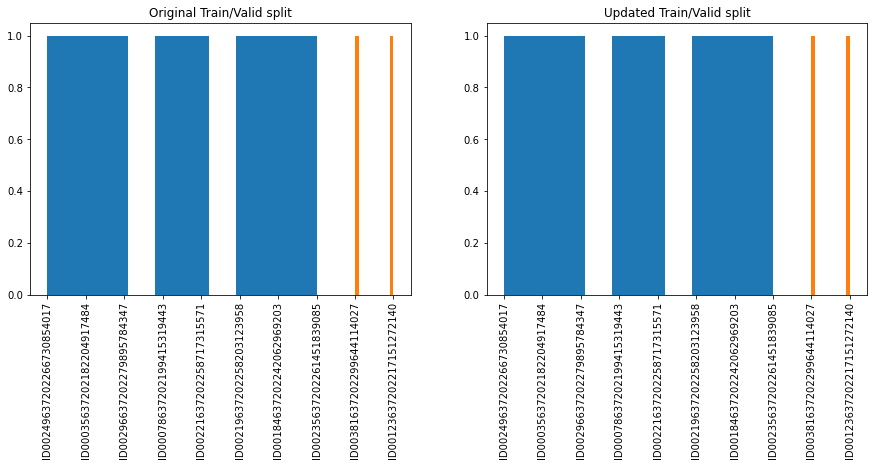

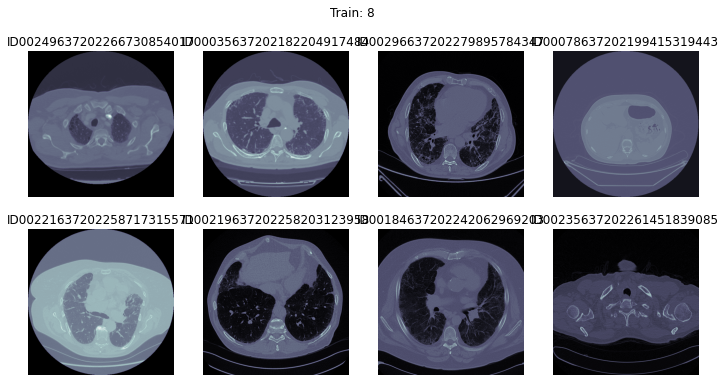

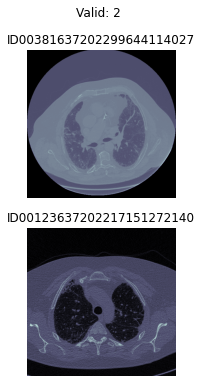

In [35]:
seed = 90
set_seed(seed)
check_duplicate(rand_items, valid_pct=0.2, seed=seed)

In the example above there are no duplicates so the train/valid sets remain the same and this is shown in the histographs where there is no overlap between the blue(train) and orange(valid) sets. `check_duplicate` also displays which patient is a duplicate and what the original validation index and the updated validation (if there is a duplicate) index looks like.

Now lets check to see what happens if there are duplicates.  In this example we use a larger dataset

In [36]:
items = get_dicom_files(source)
rand_items = random_(items, value=40)
rand_items

(#40) [Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00078637202199415319443/479.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00296637202279895784347/18.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00035637202182204917484/391.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00184637202242062969203/30.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00249637202266730854017/57.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00219637202258203123958/225.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00221637202258717315571/228.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/196.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00235637202261451839085/16.dcm'),Path('D:/Datasets/osic-pulmonary-fibrosis-progression/train/ID00381637202299644114027/249.dcm')...]

Train: 32 
 Original Validation: 8 
 Updated Validation: 6


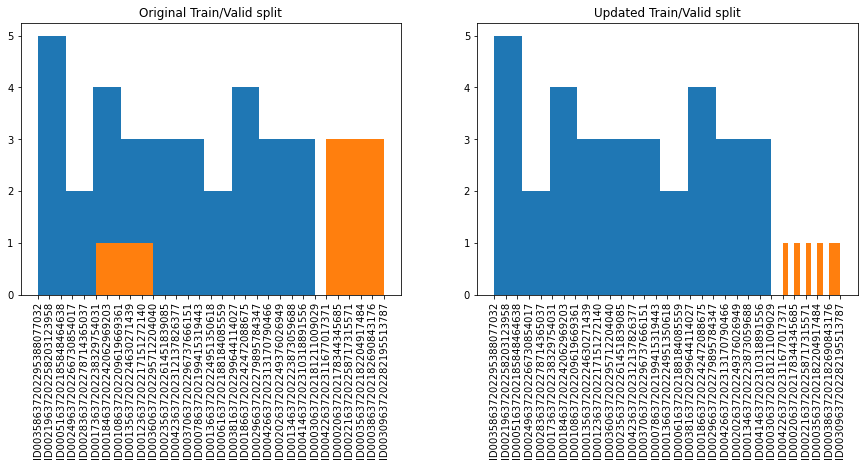

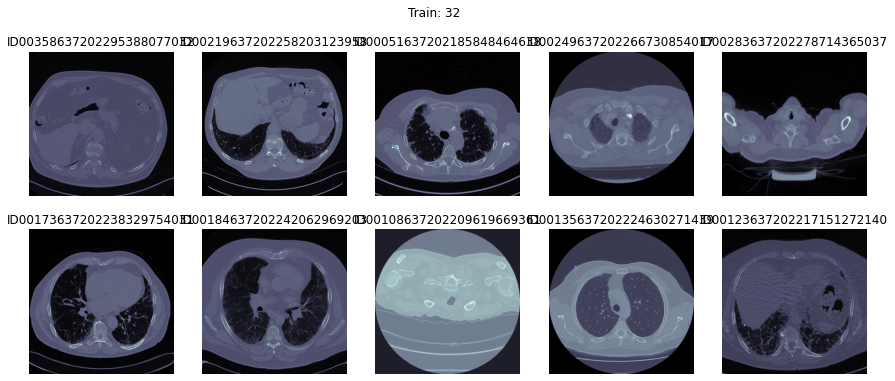

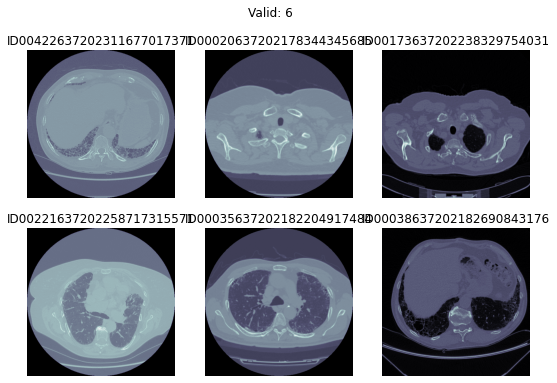

In [37]:
seed = 7
set_seed(seed)
check_duplicate(rand_items, valid_pct=0.2, seed=seed)

In the example above the original train and valid sets have duplicate, represented in the `Original Train/Valid split` histograph.  `dicomsplit` then removes the duplicates from the validation set.  This is represented in the `Updated Train/Valid split` histograph.

Lets see how `dicomsplit` works with `SIIM_SMALL` dicom dataset that is readily available in `fastai`.  In this example we use both folders `sm` and `train` so we can see how `dicomsplit` is working.

In [38]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)
items = get_dicom_files(pneumothorax_source)
items

(#500) [Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000002.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000005.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000006.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000007.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000008.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000009.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000011.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000012.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000014.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000015.dcm')...]

Train: 400 
 Original Validation: 100 
 Updated Validation: 11


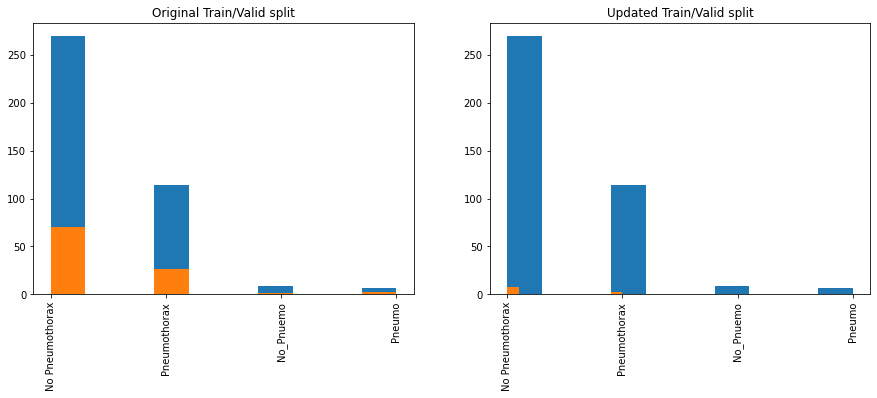

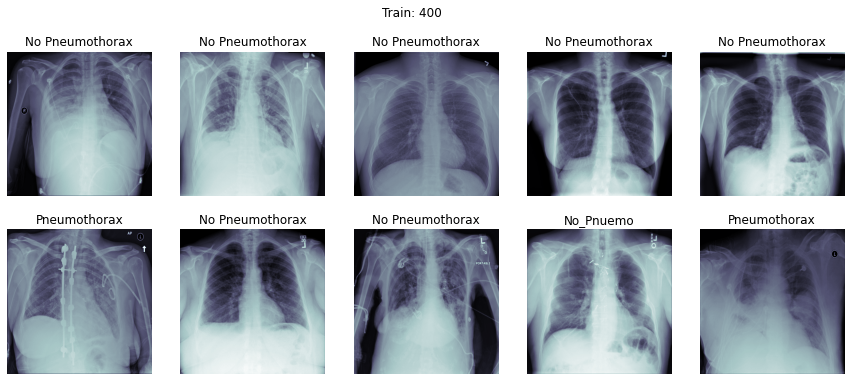

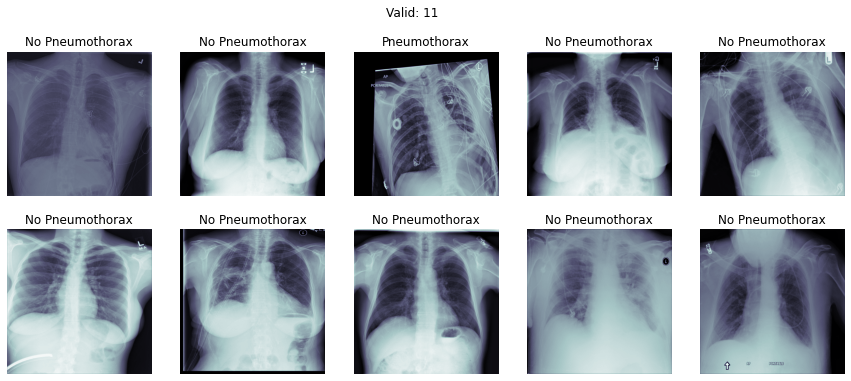

In [39]:
check_duplicate(items, valid_pct=0.2, seed=76)

In this example there are duplicates so the duplicates are removed from the validation set hence the reason why the validation set reduced from 55 to 50.

In [40]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 02_explore.ipynb.
Converted 03_preprocessing.ipynb.
Converted 04_pipeline.ipynb.
Converted 05_train.ipynb.
Converted 06_examine.ipynb.
Converted 90_tutorial.ipynb.
Converted index.ipynb.
